In [32]:
#Chefboost
import numpy as np
import pandas as pd 

class MyChefboost:
    # 1.Entropy (ID3, C4.5, C5.0)
    def _entropy(self, y):
        proportions = y.value_counts(normalize=True)
        return -sum(proportions * np.log2(proportions))

    # 2. Gini Index (CART)
    def _gini(self, y):
        proportions = y.value_counts(normalize=True)
        return 1 - sum(proportions ** 2)

    # 3. Information Gain (ID3 và C4.5)
    def _info_gain(self, df, feature, target):
        parent_entropy = self._entropy(df[target])
        values = df[feature].unique()
        weighted_entropy = 0
        
        for val in values:
            subset = df[df[feature] == val]
            weighted_entropy += (len(subset) / len(df)) * self._entropy(subset[target])
        
        return parent_entropy - weighted_entropy

    # 4. Gain ratio cho C4.5, C5.0 
    def _gain_ratio(self, df, feature, target):
        info_gain = self._info_gain(df, feature, target)
        # Split Info chính là Entropy của cột feature
        split_info = self._entropy(df[feature]) 
        return info_gain / split_info if split_info != 0 else 0

    # 5. Hàm tìm điểm chia tốt nhất
    def _find_best_split(self, df, algorithm):
        target = df.columns[-1]
        best_feature = None
        best_score = -np.inf # Khởi tạo giá trị nhỏ nhất

        for feature in df.columns[:-1]:
            if algorithm == "ID3":
                score = self._info_gain(df, feature, target)
            elif algorithm in ["C4.5", "C5.0"]:
                score = self._gain_ratio(df, feature, target)
            elif algorithm == "CART":
                # Với CART, Gini càng thấp càng tốt, 
                # nên ta dùng (1 - Gini) hoặc (-Gini) để tìm max
                score = 1 - self._calculate_gini_split(df, feature, target)
            
            if score > best_score:
                best_score = score
                best_feature = feature
                
        return best_feature, best_score

    # Hàm bổ trợ cho CART (Tính Gini trung bình trọng số sau khi chia)
    def _calculate_gini_split(self, df, feature, target):
        values = df[feature].unique()
        weighted_gini = 0
        for val in values:
            subset = df[df[feature] == val]
            weighted_gini += (len(subset) / len(df)) * self._gini(subset[target])
        return weighted_gini
    def fit(self, df, config):
        # Lấy thuật toán từ config, mặc định là ID3
        algorithm = config.get('algorithm', 'ID3')
        # Bắt đầu xây dựng cây đệ quy
        self.model = self._build_tree(df, algorithm)
        return self.model

    def _build_tree(self, df, algorithm):
        target = df.columns[-1]
        
        # TH1: Nếu tất cả các mẫu đều thuộc về một lớp (Node lá)
        if len(df[target].unique()) == 1:
            return df[target].iloc[0]

        # TH2: Nếu không còn đặc trưng nào để chia (Trả về lớp phổ biến nhất)
        if len(df.columns) == 1:
            return df[target].value_counts().idxmax()

        # Tìm đặc trưng tốt nhất để chia nhánh
        best_feature, _ = self._find_best_split(df, algorithm)
        
        # Nếu không tìm được điểm chia (trường hợp dữ liệu lỗi)
        if best_feature is None:
            return df[target].value_counts().idxmax()

        # Tạo node hiện tại
        tree = {best_feature: {}}
        
        # Chia nhánh cho từng giá trị của đặc trưng đó
        for val in df[best_feature].unique():
            subset = df[df[best_feature] == val].drop(columns=[best_feature])
            # Đệ quy xây dựng cây con
            tree[best_feature][val] = self._build_tree(subset, algorithm)
            
        return tree

    def predict(self, model, instance):
        # Nếu model không phải là dict -> tới node lá)
        if not isinstance(model, dict):
            return model
        
        # Lấy tên đặc trưng ở node hiện tại
        root_node = next(iter(model))
        # Lấy giá trị của đặc trưng đó từ dữ liệu cần dự đoán
        feature_value = instance[root_node]
        
        # Kiểm tra xem giá trị này có trong nhánh của cây không
        if feature_value in model[root_node]:
            return self.predict(model[root_node][feature_value], instance)
        else:
            # Nếu gặp giá trị lạ (chưa thấy lúc train), trả về giá trị mặc định
            return "Unknown"
import time

def run_chefboost(chef_obj, df_train, df_test, config):
    algo = config.get('algorithm', 'ID3')
    print(f"{algo} algorithm\n")
    print(f"{algo}  tree is going to be built...")
    
    # Đo thời gian
    start_time = time.time()
    model = chef_obj.fit(df_train, config)
    end_time = time.time()
    
    # Tính Accuracy trên tập train (giống mẫu của bạn)
    correct = 0
    for _, instance in df_train.iterrows():
        if chef_obj.predict(model, instance) == instance.iloc[-1]:
            correct += 1
    
    accuracy = (correct / len(df_train)) * 100
    execution_time = end_time - start_time
    
    # In thông tin hệ thống
    print(f"Accuracy:  {accuracy}% on  {len(df_train)}  instances")
    print(f"finished in  {execution_time}  seconds")
    
    # In kết quả so sánh trên tập TEST
    for _, instance in df_test.iterrows():
        prediction = chef_obj.predict(model, instance)
        actual = instance.iloc[-1]
        print(f"{actual} - {prediction}")
    
    print('\n' + '='*30 + '\n')
    return model

In [22]:
import pandas as pd 
chef = MyChefboost()

In [23]:
df = pd.read_csv('golf.txt')
df.head()

,Outlook,Temp.,Humidity,Wind,Decision
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


In [24]:
print("ID3 algorithm\n")

#set algorithm
config = {'algorithm': 'ID3'}
#train 
print("Train model on traing dataset:")
model = chef.fit(df[:8].copy(), config)
#define x 
xrow = ['Sunny','Hot','High','Weak']
xrow_instance = pd.Series(xrow, index=df.columns[:-1])
#predict
prediction = chef.predict(model,xrow_instance)
print("Prediction for given day. Should we play? {0}".format(prediction))
c = 0 
print("\nCompare predictions and expected results on TESTING dataset:")
#prediction on testing data set
for index, instance in df[8:].iterrows():
    prediction = chef.predict(model, instance)
    actual=instance['Decision']  
    print(actual,"-",prediction)
    if(actual==prediction):
        c=c+1
print("Accuracy on TESTING data set:{0}%".format(round(c/df[8:].shape[0],4) ))

ID3 algorithm

Train model on traing dataset:
Prediction for given day. Should we play? No

Compare predictions and expected results on TESTING dataset:
Yes - No
Yes - Yes
Yes - No
Yes - Yes
Yes - Yes
No - No
Accuracy on TESTING data set:0.6667%


In [25]:
print("C4.5 algorithm\n")

#set algorithm
config = {'algorithm': 'C4.5'}
model = chef.fit(df[:8], config)
#define xrow
xrow  = ['Sunny','Hot','High','Weak']
xrow_instance = pd.Series(xrow, index=df.columns[:-1])
#predict
prediction = chef.predict(model,xrow_instance)

#prediction on testing data set
for index, instance in df[8:].iterrows():
    prediction = chef.predict(model, instance)
    actual=instance['Decision']  
    print(actual,"-",prediction)
print("Accuracy on TESTING data set:{0}%".format(round(c/df[8:].shape[0],4) ))

C4.5 algorithm

Yes - No
Yes - Yes
Yes - No
Yes - Yes
Yes - Yes
No - No
Accuracy on TESTING data set:0.6667%


In [26]:
print("C5.0 algorithm\n")

#set algorithm
config = {'algorithm': 'C5.0'}
model = chef.fit(df[:8], config)
#define xrow
xrow  = ['Sunny','Hot','High','Weak']
xrow_instance = pd.Series(xrow, index=df.columns[:-1])
#predict
prediction = chef.predict(model,xrow_instance)

#prediction on testing data set
c = 0
for index, instance in df[8:].iterrows():
    prediction = chef.predict(model, instance)
    actual=instance['Decision']  
    print(actual,"-",prediction)
    if(actual==prediction):
        c=c+1
print("Accuracy on TESTING data set:{0}%".format(round(c/df[8:].shape[0],4) ))


C5.0 algorithm

Yes - No
Yes - Yes
Yes - No
Yes - Yes
Yes - Yes
No - No
Accuracy on TESTING data set:0.6667%


In [27]:
print("CART algorithm\n")

#set algorithm
config = {'algorithm': 'CART'}
model = chef.fit(df[:8], config)
#define xrow
xrow  = ['Sunny','Hot','High','Weak']
xrow_instance = pd.Series(xrow, index=df.columns[:-1])
#predict
prediction = chef.predict(model,xrow_instance)

#prediction on testing data set
print("\nCompare predictions and expected results on TESTING dataset:")
for index, instance in df[8:].iterrows():
    prediction = chef.predict(model, instance)
    actual=instance['Decision']  
    print(actual,"-",prediction)

print("Accuracy on TESTING data set:{0}%".format(round(c/df[8:].shape[0],4) ))

CART algorithm


Compare predictions and expected results on TESTING dataset:
Yes - No
Yes - Yes
Yes - No
Yes - Yes
Yes - Yes
No - No
Accuracy on TESTING data set:0.6667%


Example 2

In [13]:
df = pd.read_csv("iris.data")
df = df.sample(frac=1).reset_index(drop=True)
df.head()


,x1,x2,x3,x4,Decision
0,5.4,3.7,1.5,0.2,Iris-setosa
1,6.4,3.1,5.5,1.8,Iris-virginica
2,4.9,3.1,1.5,0.1,Iris-setosa
3,5.1,3.5,1.4,0.3,Iris-setosa
4,6.0,2.9,4.5,1.5,Iris-versicolor


In [15]:
print("ID3 algorithm\n")

#set algorithm
config = {'algorithm': 'ID3'}
model = chef.fit(df[:100].copy(), config)

#prediction on test data set
for index, instance in df[100:].iterrows():
    prediction = chef.predict(model, instance)
    actual=instance['Decision']  
    print(actual,"-",prediction)
print('\n')

print("C4.5 algorithm\n")

#set algorithm
config = {'algorithm': 'C4.5'}
model = chef.fit(df[:100].copy(), config)

#prediction on test data set
for index, instance in df[100:].iterrows():
    prediction = chef.predict(model, instance)
    actual=instance['Decision']
    print(actual,"-",prediction)
print('\n')
print("C5.0 algorithm\n")
config = {'algorithm': 'C5.0'}
model = chef.fit(df[:100].copy(), config)

#prediction on test data set
for index, instance in df[100:].iterrows():
    prediction = chef.predict(model, instance)
    actual=instance['Decision']
    print(actual,"-",prediction)


print('\n') 
print("CART algorithm\n")

#set algorithm
config = {'algorithm': 'CART'}
model = chef.fit(df[:100].copy(), config)

#prediction on test data set
for index, instance in df[100:].iterrows():
    prediction = chef.predict(model, instance)
    actual=instance['Decision']
    #print(actual,"-",prediction)

ID3 algorithm

Iris-virginica - Iris-virginica
Iris-versicolor - Iris-virginica
Iris-versicolor - Iris-versicolor
Iris-versicolor - Iris-versicolor
Iris-virginica - Iris-virginica
Iris-virginica - Iris-virginica
Iris-virginica - Unknown
Iris-versicolor - Unknown
Iris-versicolor - Iris-virginica
Iris-versicolor - Iris-versicolor
Iris-versicolor - Iris-versicolor
Iris-versicolor - Iris-versicolor
Iris-virginica - Iris-virginica
Iris-versicolor - Iris-virginica
Iris-setosa - Iris-setosa
Iris-versicolor - Iris-versicolor
Iris-versicolor - Unknown
Iris-versicolor - Iris-versicolor
Iris-versicolor - Iris-versicolor
Iris-virginica - Iris-virginica
Iris-setosa - Unknown
Iris-virginica - Iris-virginica
Iris-versicolor - Iris-versicolor
Iris-versicolor - Iris-versicolor
Iris-setosa - Iris-setosa
Iris-setosa - Iris-setosa
Iris-virginica - Iris-virginica
Iris-setosa - Iris-setosa
Iris-setosa - Iris-setosa
Iris-setosa - Iris-setosa
Iris-setosa - Unknown
Iris-versicolor - Unknown
Iris-setosa - Iris-

In [33]:

chef = MyChefboost()
df_train = df[:100].copy()
df_test = df[100:].copy()

model_id3 = run_chefboost(chef, df_train, df_test, {'algorithm': 'ID3'})
model_c45 = run_chefboost(chef, df_train, df_test, {'algorithm': 'C4.5'})
model_c50 = run_chefboost(chef, df_train, df_test, {'algorithm': 'C5.0'})
model_cart = run_chefboost(chef, df_train, df_test, {'algorithm': 'CART'})

ID3 algorithm

ID3  tree is going to be built...
Accuracy:  100.0% on  14  instances
finished in  0.014832019805908203  seconds


C4.5 algorithm

C4.5  tree is going to be built...
Accuracy:  100.0% on  14  instances
finished in  0.015843629837036133  seconds


C5.0 algorithm

C5.0  tree is going to be built...
Accuracy:  100.0% on  14  instances
finished in  0.012947797775268555  seconds


CART algorithm

CART  tree is going to be built...
Accuracy:  100.0% on  14  instances
finished in  0.008442401885986328  seconds




Example 3

135
Confusion matrix results:
[[15]]
Classification report
              precision    recall  f1-score   support

           2       1.00      1.00      1.00        15

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


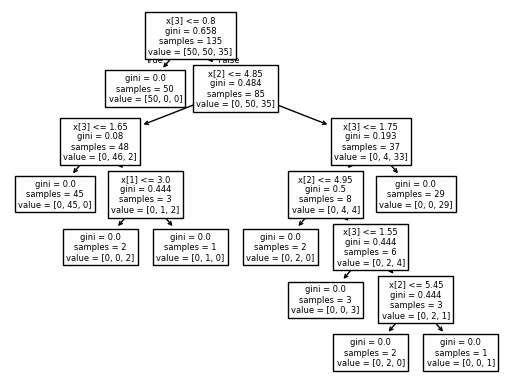

In [35]:
#scikit learn
from sklearn.datasets import load_iris
from sklearn import tree
X, y = load_iris(return_X_y=True)
tSize=int(X.shape[0]*0.9)
print(tSize)
X_train=X[0:tSize,:]
y_train=y[0:tSize]

X_test=X[tSize:,:]
y_test=y[tSize:]

clf = tree.DecisionTreeClassifier()

#train decision tree on training set
clf = clf.fit(X_train, y_train)

#predict values on testing set
y_pred=clf.predict(X_test);



tree.plot_tree(clf) 
#!pip install graphviz

from sklearn.metrics import classification_report, confusion_matrix

print("Confusion matrix results:")
print(confusion_matrix(y_test,y_pred))

print("Classification report")
print(classification_report(y_test, y_pred))